# Wave Dissipation dataset 

Mapping Wave Dissipation dataset needed for MOM6+CVMix tidal parameterization.

In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.colors as colors
from datetime import datetime

In [5]:
plot_opts = {'size':8, 'norm':colors.LogNorm(vmin=10e-7, vmax=3.0)}

### Original Forcing Data

In [6]:
src_ds = xr.open_dataset("/glade/work/altuntas/mom.input/tx0.66v1/gen_grid_190314/tidal_tx0.66v1/energy_new.nc")

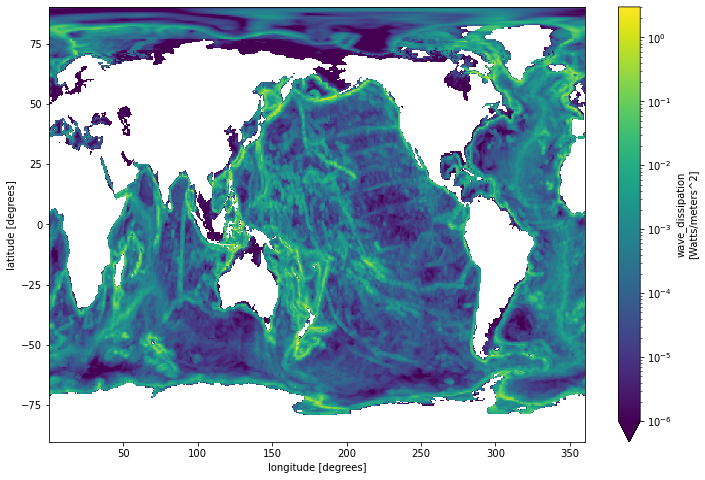

In [7]:
src_ds.wave_dissipation.plot(**plot_opts)

# Fix bad column in src

In [8]:
# Discard the first column in the src dataset. This bad column
# corresponds to 0.5 deg longitude. Then apply nearest_s2d mapping

regridder = xe.Regridder(
        src_ds.isel(longitude=slice(1,720)),
        src_ds,
        method='nearest_s2d',
        periodic=True,
    )

src_ds_fixed = regridder(src_ds.isel(longitude=slice(1,720))) 

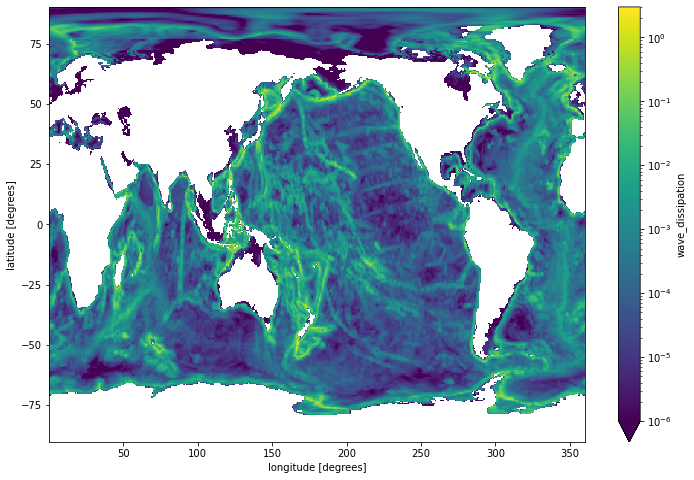

In [9]:
src_ds_fixed.wave_dissipation.plot(**plot_opts)

# Target Grid

In [10]:
dst_grid_path = "../mesh/tx1_4_grid.nc"
dst_grid = xr.open_dataset(dst_grid_path)
dst_grid = dst_grid.rename({'tlon': 'lon', 'tlat': 'lat', 'qlon':'lon_b', 'qlat': 'lat_b'})

### Conservative Regridding

In [11]:
# Conservative regridder from src grid to target grid.
regridder = xe.Regridder(
        src_ds_fixed,
        dst_grid,
        method='conservative',
        periodic=True,
    )

# Field mapped conservatively to the target grid
dst_fld = regridder(src_ds_fixed.wave_dissipation) 

/glade/u/apps/opt/conda/envs/npl-2022b/lib/python3.8/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


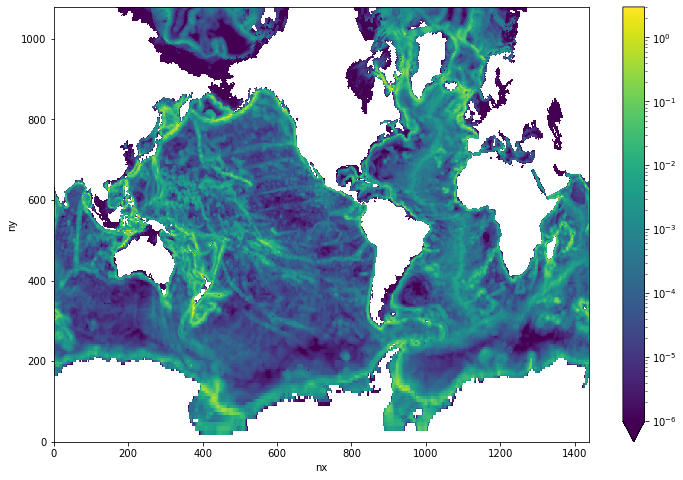

In [12]:
dst_fld.plot(**plot_opts)

### Reapply target mask:

In [13]:
dst_fld = xr.where(dst_grid.tmask>0, dst_fld, 0.0)

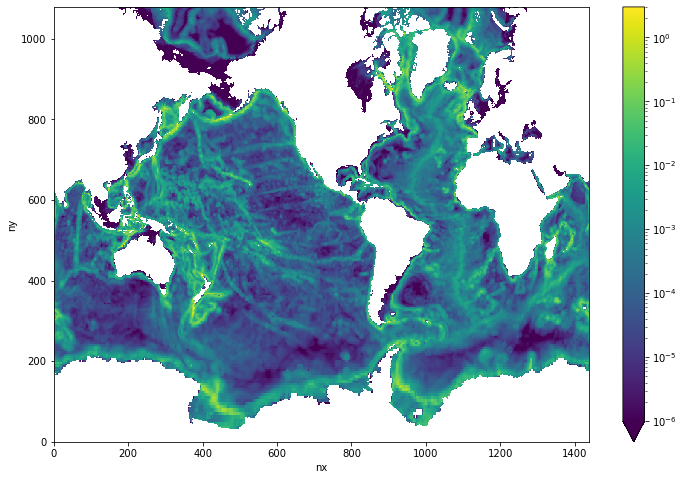

In [14]:
dst_fld.plot(**plot_opts)

### Save to file:

In [18]:
dst_ds = xr.Dataset(
    {"wave_dissipation": dst_fld},
    coords={
        'lon': dst_grid.lon, 
        'lat': dst_grid.lat, 
    },
    attrs = {
        'description': 'Estimated tidal dissipation data by S.R. Jayne. WHOI.',
        'author': 'Alper Altuntas (altuntas@ucar.edu)',
        'created': datetime.now().strftime("%Y-%d-%m %H:%M:%S")
    }
)

dst_ds.to_netcdf('energy_new_tx1_4_conserve_011023.nc')

<div class="alert alert-block alert-danger">
<b>NOTE:</b> make sure the netcdf file is in `cdf5` format! (netCDF-4 is NOT allowed)
</div>

In [19]:
!nccopy -k cdf5 energy_new_tx1_4_conserve_011023.nc energy_new_tx1_4_conserve_011023_cdf5.nc